In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os
import re
import shutil
from pathlib import Path

/data/nvs/protofer/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
def create_empty_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)

In [48]:
data_dir = 'data/mnist/train'
img_size = 28
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(img_size),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(img_size),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [49]:
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

In [43]:
def create_mnist():
    from torchvision.datasets import MNIST
    from random import random
    # from torch.utils.data import DataLoader
    mnist_dataset = MNIST('data/mnist_download', download=True)
    # mnist_loader = DataLoader(mnist_data,
    #                         batch_size=4,
    #                         shuffle=True,
    #                         num_workers=2)
    mnist_root = Path('data/mnist')
    create_empty_folder(mnist_root)
    (mnist_root / 'train').mkdir()
    (mnist_root / 'test').mkdir()
    ratio = .1
    for i, (image, label) in enumerate(mnist_dataset):
        if random() > ratio:
            folder = mnist_root / f'train/{label}'
            if not folder.exists():
                folder.mkdir()
            path = folder / f'{i:06}.png'
            image.save(path)
        else:
            folder = mnist_root / f'test/{label}'
            if not folder.exists():
                folder.mkdir()
            path = folder / f'{i:06}.png'
            image.save(path)

In [50]:
epochs = 3
steps = 0
running_loss = 0
print_every = 100
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), \
                                      labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = \
                        top_class == labels.view(*top_class.shape)
                    accuracy += \
                    torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/3.. Train loss: 1.405.. Test loss: 1.092.. Test accuracy: 0.656
Epoch 1/3.. Train loss: 1.053.. Test loss: 0.872.. Test accuracy: 0.721
Epoch 1/3.. Train loss: 0.972.. Test loss: 0.824.. Test accuracy: 0.735
Epoch 1/3.. Train loss: 0.894.. Test loss: 0.821.. Test accuracy: 0.728
Epoch 1/3.. Train loss: 0.896.. Test loss: 0.744.. Test accuracy: 0.759
Epoch 1/3.. Train loss: 0.866.. Test loss: 0.731.. Test accuracy: 0.760
Epoch 2/3.. Train loss: 0.870.. Test loss: 0.741.. Test accuracy: 0.753
Epoch 2/3.. Train loss: 0.790.. Test loss: 0.696.. Test accuracy: 0.773
Epoch 2/3.. Train loss: 0.814.. Test loss: 0.808.. Test accuracy: 0.734
Epoch 2/3.. Train loss: 0.816.. Test loss: 0.708.. Test accuracy: 0.764
Epoch 2/3.. Train loss: 0.821.. Test loss: 0.669.. Test accuracy: 0.782
Epoch 2/3.. Train loss: 0.802.. Test loss: 0.669.. Test accuracy: 0.779
Epoch 2/3.. Train loss: 0.779.. Test loss: 0.669.. Test accuracy: 0.778
Epoch 3/3.. Train loss: 0.746.. Test loss: 0.679.. Test accuracy

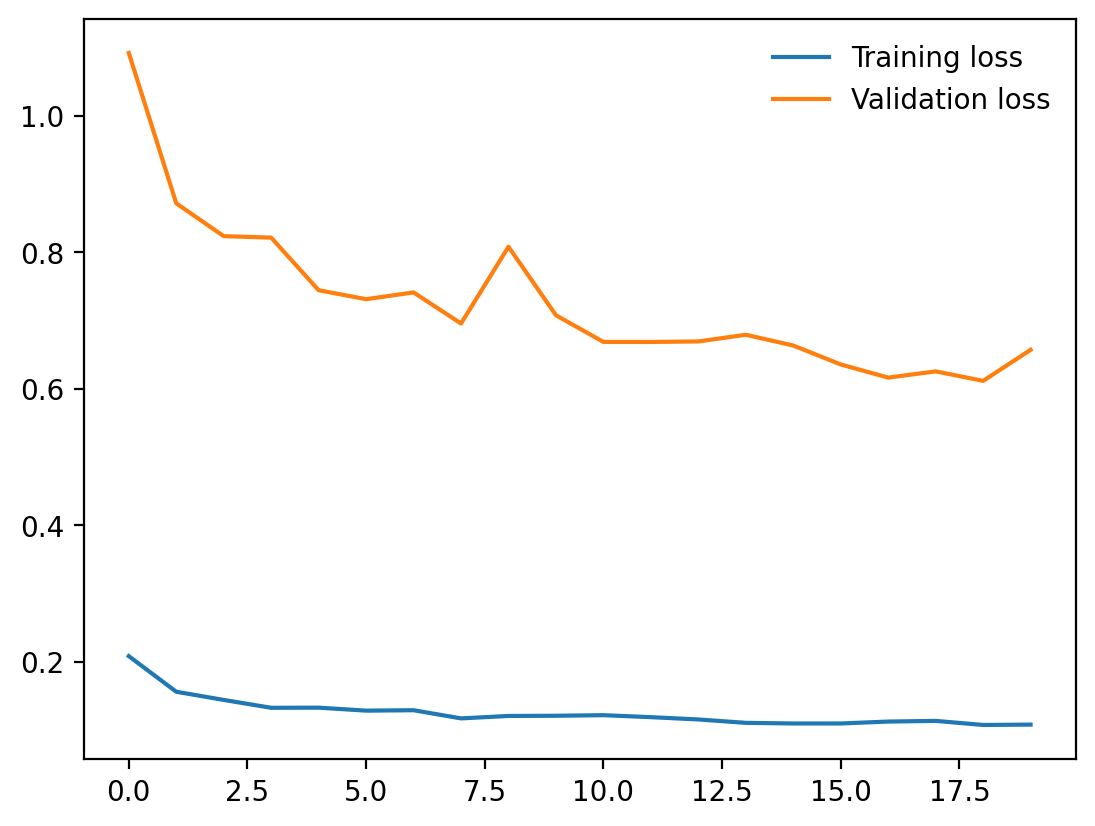

In [51]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [62]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # input = Variable(image_tensor)
    input = image_tensor.to(device)
    output = model_eval(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [58]:
model_eval = torch.load('aerialmodel.pth')
test_transforms = transforms.Compose([transforms.Resize(img_size),
                                      transforms.ToTensor()])
model_eval.eval();

In [56]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

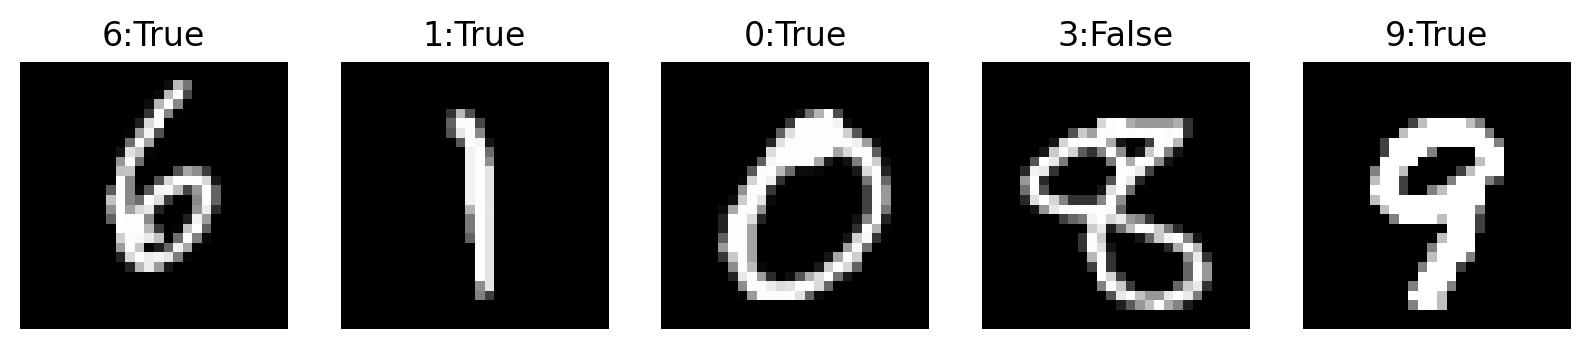

In [64]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()